# Bloque 1: Importación y Preparación Inicial

In [2]:
# Importaciones y Configuración Inicial

import pandas as pd
import boto3
import os
from io import BytesIO
from zipfile import ZipFile
from dotenv import load_dotenv
from collections import Counter

# Cargar variables de entorno desde el archivo .env
load_dotenv()

# Crear una instancia de cliente de S3 utilizando las credenciales de entorno
s3 = boto3.client(
    's3',
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY")
)

# Definir el nombre del archivo ZIP en S3 y el nombre del archivo CSV dentro del ZIP
nombre_archivo_zip = "bcra-data-delivery-2024-04-25.zip"
nombre_archivo_csv = "bcra-data-delivery-2024-04-25/raw_market_candles_1d.csv"

In [3]:
# Descargar y Procesar Datos

try:
    # Descargar el archivo ZIP desde S3
    objeto_zip = s3.get_object(Bucket='coinmetrics.io', Key=nombre_archivo_zip)
    
    # Leer el contenido del archivo ZIP en memoria y cargar el CSV en un DataFrame de pandas
    with ZipFile(BytesIO(objeto_zip['Body'].read())) as archivo_zip:
        with archivo_zip.open(nombre_archivo_csv) as csv_file:
            df = pd.read_csv(csv_file)

    # Dividir la columna 'market' en 'crypto', 'fiat', y 'market_type'
    df[['exchange', 'crypto', 'fiat', 'market_type']] = df['market'].str.split('-', expand=True)
    
    # Convertir la columna 'time' a tipo datetime si no lo está
    df['time'] = pd.to_datetime(df['time'])
    
    # Filtrar solo los datos de mercados spot
    df_spot = df[df['market_type'] == 'spot']
    
    # Lista de monedas fiat
    fiat = ['aud', 'usd', 'jpy', 'gbp', 'eur', 'cad', 'ars', 'brl', 'ngn', 'pln', 'ron', 'rub', 'zar', 'try', 'uah', 'inr']
    
    # Lista para rastrear los cambios
    cambios = []

    # Verificar y corregir las ubicaciones de las monedas fiat y cripto
    for index, row in df_spot.iterrows():
        if row['crypto'] in fiat:
            # Intercambiar las columnas crypto y fiat
            df_spot.at[index, 'crypto'], df_spot.at[index, 'fiat'] = row['fiat'], row['crypto']
            cambios.append((row['fiat'], row['crypto']))

    # Agrupar por 'time', 'fiat' y 'crypto', y calcular agregados
    df_grouped = df_spot.groupby(['time', 'fiat', 'crypto']).agg({
        'price_close': 'mean',
        'volume': 'sum',
        'candle_usd_volume': 'sum',
        'candle_trades_count': 'sum'
    }).reset_index()
    
    # Renombrar columnas para mayor claridad
    df_grouped.rename(columns={
        'price_close': 'avg_price_close', 
        'volume': 'total_volume', 
        'candle_usd_volume': 'total_usd_volume',
        'candle_trades_count': 'total_trades_count'
    }, inplace=True)

    # Mostrar mensaje si hubo cambios de ubicaciones
    if cambios:
        cambios_contador = Counter(cambios)
        print(f"Se realizaron {len(cambios)} cambios de ubicación en las monedas fiat y crypto:")
        for par, count in cambios_contador.items():
            print(f"Par invertido: {par[1]} - {par[0]} ({count} veces)")
    else:
        print("No se realizaron cambios de ubicación en las monedas fiat y crypto.")

except Exception as e:
    print(f"Error al procesar el archivo: {e}")


Se realizaron 49393 cambios de ubicación en las monedas fiat y crypto:
Par invertido: aud - busd (1036 veces)
Par invertido: aud - usdc (329 veces)
Par invertido: aud - usdt (1029 veces)
Par invertido: eur - busd (1439 veces)
Par invertido: eur - usdc (37 veces)
Par invertido: eur - usdt (3545 veces)
Par invertido: gbp - busd (1240 veces)
Par invertido: gbp - usdt (2747 veces)
Par invertido: gbp - eurt (793 veces)
Par invertido: jpy - usdt (793 veces)
Par invertido: try - usdt (890 veces)
Par invertido: eur - usd (4777 veces)
Par invertido: gbp - eur (1106 veces)
Par invertido: gbp - usd (4202 veces)
Par invertido: usd - eur (1292 veces)
Par invertido: usd - usdc (19 veces)
Par invertido: aud - usd (2184 veces)
Par invertido: brl - usd (338 veces)
Par invertido: brl - usdt (338 veces)
Par invertido: cad - usd (1279 veces)
Par invertido: usd - jpy (1686 veces)
Par invertido: usd - try (274 veces)
Par invertido: ron - usdt (2290 veces)
Par invertido: inr - usdt (570 veces)
Par invertido:

# Anexo: análisis de ustd vs btc vs fiat

In [96]:
import pandas as pd
import os

# Datos de población (en niveles, no en millones)
poblacion = {
    'usd': 331_000_000,
    'ars': 45_000_000,
    'aud': 25_000_000,
    'brl': 213_000_000,
    'cad': 38_000_000,
    'eur': 447_000_000,
    'gbp': 67_000_000,
    'inr': 1_380_000_000,
    'jpy': 126_000_000,
    'ngn': 206_000_000,
    'pln': 38_000_000,
    'ron': 19_000_000,
    'rub': 146_000_000,
    'try': 84_000_000,
    'uah': 41_000_000,
    'zar': 60_000_000
}

# Convertir los datos de población a un DataFrame
df_poblacion = pd.DataFrame(list(poblacion.items()), columns=['fiat', 'population'])

# Asegurarse de que no haya conflicto de nombres
if 'population' in df_grouped.columns:
    df_grouped = df_grouped.drop(columns=['population'])

# Agregar la columna de población al DataFrame original
df_grouped = df_grouped.merge(df_poblacion, on='fiat', how='left')

# Filtrar los datos para incluir solo USDT y BTC
df_usdt_btc = df_grouped[df_grouped['crypto'].isin(['usdt', 'btc'])]

# Verificar que los volúmenes estén en niveles adecuados
print(df_usdt_btc[['fiat', 'crypto', 'total_usd_volume', 'population']].head())

# Calcular el volumen per cápita y convertir a volumen por cada 1,000 habitantes
df_usdt_btc['total_usd_volume_per_1000_capita'] = (df_usdt_btc['total_usd_volume'] / df_usdt_btc['population']) * 1_000

# Calcular estadísticas descriptivas para volúmenes de trading per cápita en volúmenes por cada 1,000 habitantes
descriptive_stats_per_1000_capita = df_usdt_btc.groupby(['fiat', 'crypto'])['total_usd_volume_per_1000_capita'].describe().unstack()

# Filtrar las columnas deseadas
columns_to_keep = ['count', 'mean', 'std']
descriptive_stats_per_1000_capita = descriptive_stats_per_1000_capita.loc[:, columns_to_keep]

# Redondear a 2 decimales
descriptive_stats_per_1000_capita = descriptive_stats_per_1000_capita.round(2)

# Ajustar los encabezados de las columnas para LaTeX
descriptive_stats_per_1000_capita.columns = pd.MultiIndex.from_tuples([('BTC', 'count'), ('USDT', 'count'), 
                                                                       ('BTC', 'mean'), ('USDT', 'mean'), 
                                                                       ('BTC', 'std'), ('USDT', 'std')])

   fiat crypto  total_usd_volume  population
0   ars    btc      4.137384e+03    45000000
1   aud    btc      3.895525e+04    25000000
4   brl    btc      7.016746e+03   213000000
6   cad    btc      2.494938e+05    38000000
14  eur    btc      2.967131e+07   447000000


/tmp/ipykernel_20441/1161752619.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [97]:
# Formatear la tabla en LaTeX usando booktabs
latex_table = descriptive_stats_per_1000_capita.to_latex(
    index=True, 
    float_format="%.2f", 
    caption="Descriptive Statistics of Trading Volumes per 1,000 Capita in USD for USDT and BTC", 
    label="tab:descriptive_stats", 
    header=True, 
    column_format='lcccccc', 
    multicolumn=True, 
    multicolumn_format='c',
    escape=False
)

# Ajustar los encabezados de las columnas en LaTeX
latex_table = latex_table.replace('BTC', '\\textbf{BTC}').replace('USDT', '\\textbf{USDT}')
latex_table = latex_table.replace('count', '\\textbf{count}').replace('mean', '\\textbf{mean}')
latex_table = latex_table.replace('std', '\\textbf{std}')
latex_table = latex_table.replace('{lcccccc}', '{lcccccc}')

# Insertar líneas adicionales para mejorar la legibilidad
latex_table = latex_table.replace('\\begin{tabular}{lcccccc}', 
                                  '\\begin{tabular}{lcccccc}\n\\toprule')
latex_table = latex_table.replace('\\end{tabular}', '\\bottomrule\n\\end{tabular}')
latex_table = latex_table.replace('\\midrule\n', '\\midrule\nfiat & \\textbf{BTC} & \\textbf{USDT} & \\textbf{BTC} & \\textbf{USDT} & \\textbf{BTC} & \\textbf{USDT} \\\\\n')

# Guardar la tabla en un archivo .tex en la subcarpeta 'tables'
os.makedirs('tables', exist_ok=True)
with open('tables/descriptive_stats_usdt_btc_per_1000_capita.tex', 'w') as f:
    f.write(latex_table)

# Mostrar la tabla en formato LaTeX
print(latex_table)


\begin{table}
\caption{Descriptive Statistics of Trading Volumes per 1,000 Capita in USD for \textbf{USDT} and \textbf{BTC}}
\label{tab:descriptive_stats}
\begin{tabular}{lcccccc}
\toprule
\toprule
 & \textbf{BTC} & \textbf{USDT} & \textbf{BTC} & \textbf{USDT} & \textbf{BTC} & \textbf{USDT} \\
 & \textbf{count} & \textbf{count} & \textbf{mean} & \textbf{mean} & \textbf{std} & \textbf{std} \\
fiat &  &  &  &  &  &  \\
\midrule
fiat & \textbf{BTC} & \textbf{USDT} & \textbf{BTC} & \textbf{USDT} & \textbf{BTC} & \textbf{USDT} \\
ars & 1812.00 & 358.00 & 1.03 & 15.67 & 1.17 & 16.42 \\
aud & 1936.00 & 1352.00 & 261.35 & 435.05 & 379.28 & 440.91 \\
brl & 1936.00 & 1444.00 & 33.11 & 54.82 & 40.03 & 48.34 \\
cad & 1936.00 & 1584.00 & 44.60 & 20.83 & 48.04 & 19.25 \\
eur & 1936.00 & 1584.00 & 479.06 & 253.58 & 594.95 & 218.81 \\
gbp & 1936.00 & 1584.00 & 662.28 & 306.18 & 970.52 & 379.52 \\
inr & 1508.00 & 570.00 & 0.12 & 0.23 & 0.52 & 0.44 \\
jpy & 1936.00 & 1449.00 & 1981.16 & 0.88 & 1899.00 &

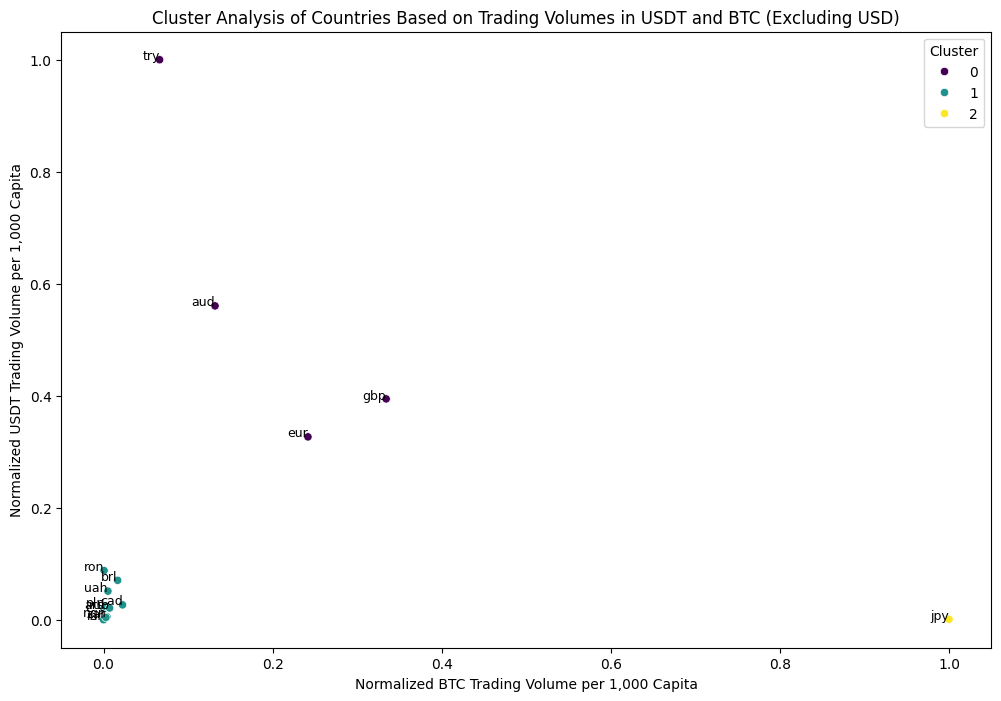

In [111]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar los datos para excluir el USD
df_filtered = df_usdt_btc[df_usdt_btc['fiat'] != 'usd']

# Pivotar los datos para tener columnas separadas para USDT y BTC
pivot_df = df_filtered.pivot_table(index='fiat', columns='crypto', values='total_usd_volume_per_1000_capita', aggfunc='mean').reset_index()

# Asegurarse de que no haya NaN en los datos
pivot_df = pivot_df.dropna(subset=['btc', 'usdt'])

# Normalizar los datos usando Min-Max Scaling
scaler = MinMaxScaler()
pivot_df[['btc', 'usdt']] = scaler.fit_transform(pivot_df[['btc', 'usdt']])

# Realizar el análisis de clúster
kmeans = KMeans(n_clusters=3, random_state=42).fit(pivot_df[['btc', 'usdt']])
pivot_df['cluster'] = kmeans.labels_

# Graficar los clústeres con etiquetas
plt.figure(figsize=(12, 8))
sns.scatterplot(data=pivot_df, x='btc', y='usdt', hue='cluster', palette='viridis')

# Agregar etiquetas a los puntos
for i in range(pivot_df.shape[0]):
    plt.text(pivot_df['btc'][i], pivot_df['usdt'][i], pivot_df['fiat'][i], fontsize=9, ha='right')

plt.title('Cluster Analysis of Countries Based on Trading Volumes in USDT and BTC (Excluding USD)')
plt.xlabel('Normalized BTC Trading Volume per 1,000 Capita')
plt.ylabel('Normalized USDT Trading Volume per 1,000 Capita')
plt.legend(title='Cluster')
plt.show()


# Bloque 2: Definición de la Variable Dependiente

Este bloque incluye las transformaciones necesarias para definir las variables dependientes a partir de los datos preparados.


In [4]:

import numpy as np

def define_dependent_variables(df_spot):
    # Agrupar por 'time', 'fiat' y 'crypto', y calcular agregados
    df_grouped = df_spot.groupby(['time', 'fiat', 'crypto']).agg({
        'price_close': 'mean',
        'volume': 'sum',
        'candle_usd_volume': 'sum',
        'candle_trades_count': 'sum'
    }).reset_index()
    
    # Renombrar columnas para mayor claridad
    df_grouped.rename(columns={
        'price_close': 'avg_price_close', 
        'volume': 'total_volume', 
        'candle_usd_volume': 'total_usd_volume',
        'candle_trades_count': 'total_trades_count'
    }, inplace=True)

    # Transformaciones logarítmicas sobre las variables de volumen y transacciones
    df_grouped['log_total_volume'] = df_grouped['total_volume'].apply(lambda x: np.log(x + 1))
    df_grouped['log_total_usd_volume'] = df_grouped['total_usd_volume'].apply(lambda x: np.log(x + 1))
    df_grouped['log_total_trades_count'] = df_grouped['total_trades_count'].apply(lambda x: np.log(x + 1))
    
    # Calcular promedios móviles para detrending
    df_grouped.set_index('time', inplace=True)
    df_grouped['ma_log_total_volume'] = df_grouped.groupby(['fiat', 'crypto'])['log_total_volume'].transform(lambda x: x.rolling(window=15, min_periods=1).mean())
    df_grouped['ma_log_total_usd_volume'] = df_grouped.groupby(['fiat', 'crypto'])['log_total_usd_volume'].transform(lambda x: x.rolling(window=15, min_periods=1).mean())
    df_grouped['ma_log_total_trades_count'] = df_grouped.groupby(['fiat', 'crypto'])['log_total_trades_count'].transform(lambda x: x.rolling(window=15, min_periods=1).mean())

    # Detrending restando el promedio móvil
    df_grouped['detrended_log_total_volume'] = df_grouped['log_total_volume'] - df_grouped['ma_log_total_volume']
    df_grouped['detrended_log_total_usd_volume'] = df_grouped['log_total_usd_volume'] - df_grouped['ma_log_total_usd_volume']
    df_grouped['detrended_log_total_trades_count'] = df_grouped['log_total_trades_count'] - df_grouped['ma_log_total_trades_count']
    
    # Restablecer el índice de tiempo
    df_grouped.reset_index(inplace=True)
    
    return df_grouped

# Definir variables dependientes
if df_spot is not None:
    df_grouped = define_dependent_variables(df_spot)
    print(df_grouped.head())


                       time fiat crypto  avg_price_close  total_volume  \
0 2019-01-01 00:00:00+00:00  ars    btc    156327.190000      0.809702   
1 2019-01-01 00:00:00+00:00  aud    btc      5544.660305      7.190061   
2 2019-01-01 00:00:00+00:00  aud    eth       189.982970     84.203687   
3 2019-01-01 00:00:00+00:00  aud   qash         0.154000     98.674680   
4 2019-01-01 00:00:00+00:00  brl    btc     15454.880000      1.491677   

   total_usd_volume  total_trades_count  log_total_volume  \
0       4137.384134                  28          0.593162   
1      38955.253960                 109          2.102921   
2      11374.420860                  32          4.445045   
3         10.641136                   2          4.601912   
4       7016.746200                  16          0.912956   

   log_total_usd_volume  log_total_trades_count  ma_log_total_volume  \
0              8.328061                3.367296             0.593162   
1             10.570195                4.700

# Análisis gráfico

In [10]:
# Convertir los valores a millones
df_usdt['total_volume_millions'] = df_usdt['total_volume'] / 1e6

# Resumen estadístico por moneda fiat en millones
summary_stats_levels_millions = df_usdt.groupby('fiat')['total_volume_millions'].describe()
print(summary_stats_levels_millions)


       count        mean         std       min        25%         50%  \
fiat                                                                    
ars    358.0    1.278054    2.901290  0.033602   0.223756    0.432444   
aud   1352.0   14.758726   14.920983  0.103893   1.952912   12.314131   
brl   1444.0   11.710159   10.281512  0.000000   3.818493   10.051006   
cad   1584.0    0.824261    0.792651  0.000117   0.233389    0.648556   
eur   1584.0  108.802577   92.887579  0.026951  29.779867  108.411246   
gbp   1584.0   17.576372   19.492332  0.000000   4.404336   15.580742   
inr    570.0    4.284956    5.272147  0.096470   1.901909    3.037733   
jpy   1449.0   11.317070  103.451833  0.000000   0.006583    0.112100   
ngn   1274.0    0.895450    1.887897  0.019695   0.122515    0.349351   
pln    525.0    0.815082    0.928804  0.000000   0.192009    0.572691   
ron    814.0    1.148669    1.348425  0.055385   0.257095    0.583507   
rub   1578.0    2.397215    3.417091  0.000245   0.

/tmp/ipykernel_20441/2811527509.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [5]:
!pip install plotly


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
